# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе своего анализа мы:

1. Выясним, какие факторы влияют на зарплату специалиста Data Scientist.
2. Ответим на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


Данные представлены CSV-файлом: ["Data Science Job Salaries"](./data/ds_salaries.csv) и содержат столбцы:
- *work_year* - Год, в котором была выплачена зарплата.
- *experience_level* - Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
- *employment_type* - Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
- *job_title* - Роль, в которой соискатель работал в течение года.
- *salary* - Общая выплаченная валовая сумма заработной платы.
- *salary_currency* - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- *salary_in_usd* - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
- *employee_residence* - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- *remote_ratio* - Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
- *company_location* - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- *company_size* - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).



## Загрузка данных

In [170]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

colormap_def = 'jet'

sns.set_theme(rc={'figure.figsize':(15, 5)})

# загружаем датасет
data = pd.read_csv('./data/ds_salaries.csv', sep=',')
# удалим колонку с индексом
data = data.drop(columns='Unnamed: 0', axis=1)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [171]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB


Датасет содержит 607 записей без пропусков.

Проверим таблицу на наличие полных дупликатов и удалим, если такие есть

In [173]:
data_dup = data[data.duplicated()]
if (data_dup.shape[0] != 0):
    print(f'Датасет содержит {data_dup.shape[0]} дубликатов')
    data = data.drop_duplicates()
    print(f'После удаления полных дубликатов осталось {data.shape[0]} записей')
else:
    print('Датасет не содержит дубликатов')

Датасет содержит 42 дубликатов
После удаления полных дубликатов осталось 565 записей


## Распределение ЗП для Data Scientist

Посмотрим на распределние заработной платы для профессии Data Scientist. Для удобства будем строить график по колонке *salary_in_usd* - ЗП приведенная к долларам США.

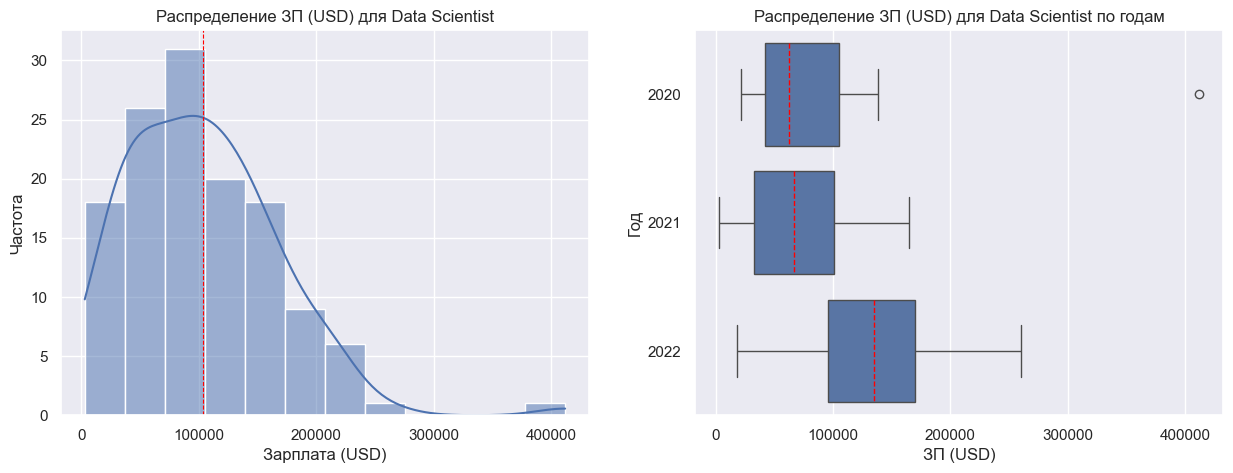

In [174]:
# отфильтруем записи для профессии "Data Scientist"
data_ds = data[data['job_title'] == 'Data Scientist']

# построим гистограмму распределения ЗП в долларах США, а также коробчатые диаграммы в разрезе годов

figure, (ax1, ax2) = plt.subplots(ncols=2)

sns.histplot(data_ds['salary_in_usd'], kde=True, ax=ax1)
ax1.set(xlabel='Зарплата (USD)', ylabel='Частота')
ax1.set_title('Распределение ЗП (USD) для Data Scientist')
ax1.axvline(data_ds['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_ds, x="salary_in_usd", y="work_year", ax=ax2, orient='h', medianprops={"color": "red", "linestyle": '--'})
ax2.set(xlabel='ЗП (USD)')
ax2.set(ylabel='Год')
ax2.set_title('Распределение ЗП (USD) для Data Scientist по годам')

plt.show();


In [175]:
# Посмотрим на распределение доходов Data Scientist по годам в числах

data_ds.groupby('work_year')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


#### Выводы

- ЗП для специалиста по Data Scientist распределена равномерно с пиком в районе 100 тыс. долларов в год

- Медианная ЗП растет год к году, особенно заметен рост в 2022 году.

- Количество записей растет год к году, что говорит о растущем спросе на сотрудников  Data Scientist и готовности компаний тратить деньги на специалистов по данным.

In [176]:
# Кроме того, видим единственный выброс в 2020 году в размере 400тыс долларов в год, посмотрим на эту строку
data_ds[data_ds['salary_in_usd'] > 350000].head()

# можно предположить, что при вводе данных была допущена ошибка и salary_in_usd должно быть 41200, выглядит реальным по коробчатой диаграмме за 2020 год

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
63,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L


## ЗП Data Scientist и Data Engineer в 2022 году

Сравним ЗП в 2022 году с помощью коробчатых диаграмм. 

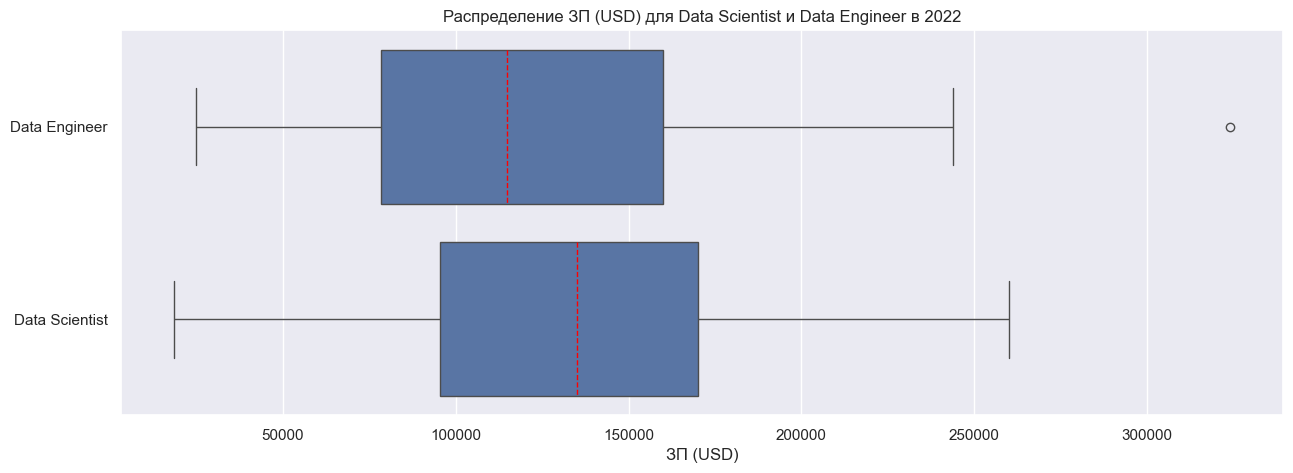

In [177]:
mask_job_title = (data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')
mask_year = data['work_year'] == 2022

data_ds_and_de_2022 = data[mask_job_title & mask_year]

ax2 = sns.boxplot(data_ds_and_de_2022, x="salary_in_usd", y="job_title", orient='h', medianprops={"color": "red", "linestyle": '--'})
ax2.set(ylabel='')
ax2.set(xlabel='ЗП (USD)')
ax2.set_title('Распределение ЗП (USD) для Data Scientist и Data Engineer в 2022')
plt.show()

In [178]:
# Из графика видно, что специалисты Data Engineer, в среднем, заработали меньше, чем Data Scientist.
# Посмотрим на числовые значения

data_ds_and_de_2022.groupby('job_title')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,79.0,124651.78,57846.84,25000.0,78526.0,115000.0,160040.0,324000.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


#### Вывод

- Средняя и медианная ЗП в 2022 году для Data Scientist выше, чем для Data Engineer

## ЗП специалистов Data Scientist в компаниях различных размеров

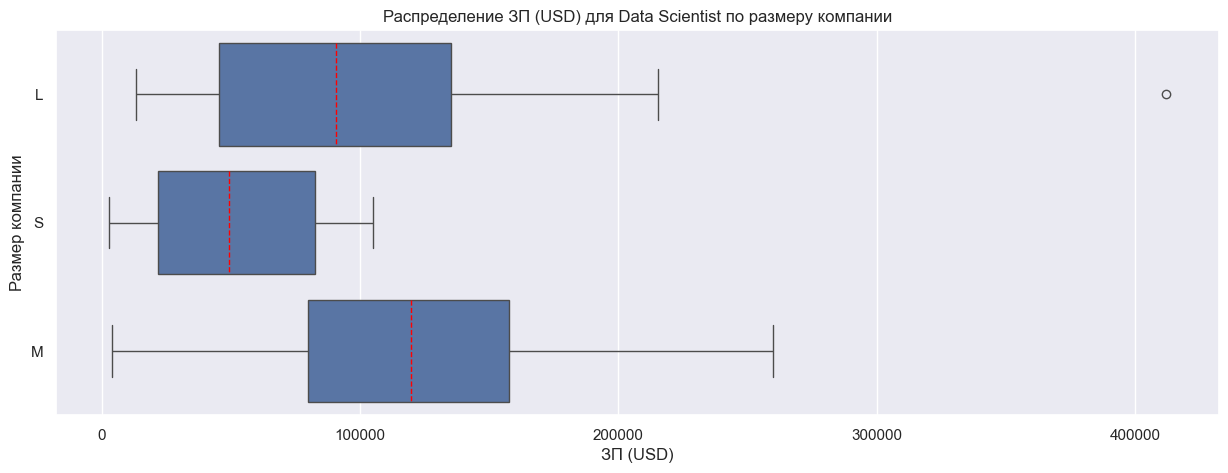

In [179]:
ax2 = sns.boxplot(data_ds, x="salary_in_usd", y="company_size", orient='h', medianprops={"color": "red", "linestyle": '--'})
ax2.set(ylabel='Размер компании')
ax2.set(xlabel='ЗП (USD)')
ax2.set_title('Распределение ЗП (USD) для Data Scientist по размеру компании')
plt.show()

#### Выводы

- Из графиков видим, что средний и медианный уровень ЗП для Data Scientist зависит от размеров компании.

- Максимальные значения наблюдаются для компаний среднего размера

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

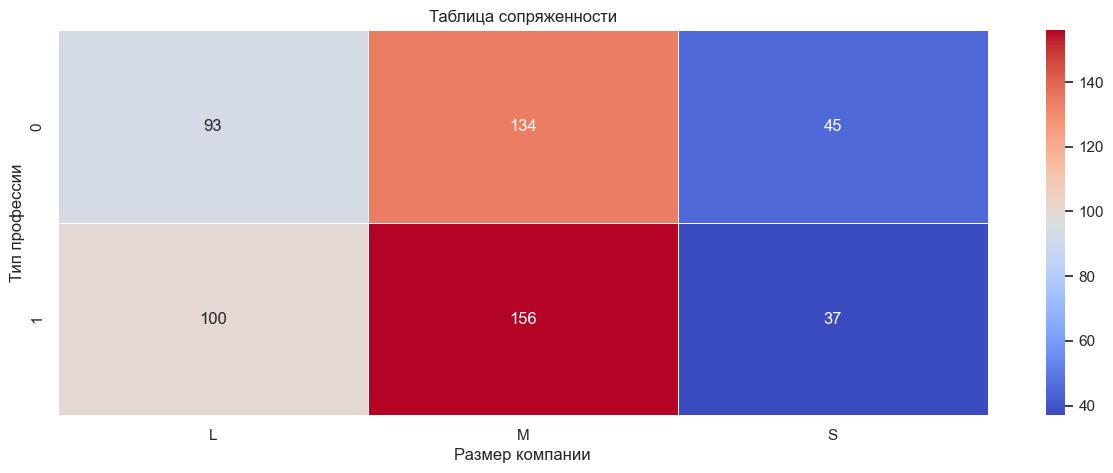

In [196]:
# создадим новое флаговое поле "job_type" - принимает значени 1, если job_title содержит ('Data Scientist', 'Data Engineer'), иначе 0
data['job_type'] = data['job_title'].apply(lambda x: 1 if (x.lower().find('data scientist') >= 0 or x.lower().find('data engineer') >= 0) else 0)


# построим сводную таблицу: cгруппируем по job_type и company_size, значениями ячеек будет количество записей
cross_tab = pd.crosstab(index=data['job_type'], columns=data['company_size'])

ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='0', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Тип профессии')
plt.title('Таблица сопряженности')
plt.show()

#### Вывод

 - Из графика можно заметить, что для компаний среднего и большого размеров, востребованность Data Scientist и Data Engineer выше, чем других профессий. 

# Статистический анализ


Проверим наши наблюдения/выводы статистическими тестами

In [181]:
# Напишем функцию, которая на вход принимает некоторую последовательность чисел и отвечает на вопрос, является ли распределение нормальным (True) или нет (False)
# Для проверки на нормальность будем использовать тест Шапиро-Уилка
def is_normal_distribution(data, title='') -> bool:
    # валидация не требуется, все есть в stats.shapiro()
    global alpha
    p = stats.shapiro(data)[1]
    if p <= alpha:
        # отвергаем нулевую гипотезу о нормальности распределения
        print('{} p-значение {:.3f} меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(title, p, alpha))
        return False    
    
    print('{} p-значение {:.3f} больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(title, p, alpha))
    return True


# Напишем функцию, которая принимает решение отвергать ли нулевую гипотезу в пользу альтернативной или нет
def decline_zero_hypothesis(p: float) -> bool:
    global alpha
    if p <= alpha:
        print('p-значение {:.3f} меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(p, alpha))
        return True
    
    print('p-значение {:.3f} больше, чем заданный уровень значимости {:.2f}. Нет оснований отвергать нулевую гипотезу.'.format(p, alpha))
    return False

# Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Из графиков мы видели, что доходы растут год к году. Проверим эти наблюдения статистически


**Сформулируем нулевую и альтернативные гипотезы**

- *Нулевая гипотеза* ($H_0$): доход специалистов Data Scientist в 2020 году ($μ_0$) статистически равен доходу в 2021 ($μ_1$) и 2022 ($μ_2$).

$$ H_0 : μ_0 = μ_1 = μ_2$$

- *Альтернативная гипотеза* ($H_1$): доход специалистов Data Scientist в 2020 году ($μ_0$) отличается от дохода в 2021 ($μ_1$) и 2022 ($μ_2$).

$$ H_1 : μ_0 ≠ μ_1 ≠ μ_2$$

**Проверим распределение доходов на нормальность**

Для этого выполним проверку каждой группы - доходы за 2020, 2021 и 2022 - независимо.

*Важно:* Поскольку мы сравниваем 3 группы данных, нам необходимо выбрать одинаковое количество элементов для каждой из анализируемых выборок.

In [182]:
# Определим минимальную длину выборки
min_len = 9999999
for year in (2020, 2021, 2022):
    v = data_ds[data_ds['work_year'] == year]['salary_in_usd']
    if v.count() < min_len:
        min_len = v.count()
print("Минимальная длина выборки:", min_len)

res = True
salary_in_usd_by_years = []
for year in (2020, 2021, 2022):
    v = data_ds[data_ds['work_year'] == year]['salary_in_usd']
    res &= is_normal_distribution(v, f'Для {year}: ')
    
    if (v.count() > min_len):
        v = v[:min_len] # берем первые min_len значений, 
    salary_in_usd_by_years.append(v)
    

Минимальная длина выборки: 21
Для 2020:  p-значение 0.000 меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:  p-значение 0.107 больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:  p-значение 0.676 больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий *Краскела-Уоллиса*.

**Проведём тест**

In [199]:
# Выполним статистический тест по итогам проверки на нормальность
_, p = stats.kruskal(*salary_in_usd_by_years)    
decline_zero_hypothesis(p);

p-значение 0.000 меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


И так, мы пришли к выводу, что доход специалистов Data Scientist меняется год к году. Но мы не ответили на вопрос есть ли рост. 

**Сформулируем нулевую и альтернативные гипотезы для данных 2020 и 2021 годов**

- *Нулевая гипотеза* ($H_0$): доход специалистов Data Scientist в 2020 году ($μ_0$) статистически больше или равен доходу в 2021 ($μ_1$).

$$ H_0 : μ_0 >= μ_1$$

- *Альтернативная гипотеза* ($H_1$): доход специалистов Data Scientist в 2020 году ($μ_0$) меньше дохода в 2021 ($μ_1$).

$$ H_1 : μ_0 < μ_1$$


**Сформулируем нулевую и альтернативные гипотезы для данных 2021 и 2022 годов**

- *Нулевая гипотеза* ($H_0$): доход специалистов Data Scientist в 2021 году ($μ_1$) статистически больше или равен доходу в 2022 ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

- *Альтернативная гипотеза* ($H_1$): доход специалистов Data Scientist в 2021 году ($μ_1$) меньше дохода в 2022 ($μ_2$).

$$ H_1 : μ_1 < μ_2$$


**Тестирование на нормальность**
Мы уже провели тестирование и можем 
1. для сравнения данных 2020 и 2021 года использовать *U-критерий Манна-Уитни*
2. для сравнения данных 2021 и 2022 года использовать *двухвыборочный t-критерий*

In [184]:
p1 = stats.mannwhitneyu(salary_in_usd_by_years[0], salary_in_usd_by_years[1], alternative='less').pvalue
print("Для 2020 и 2021 годов: ")
decline_zero_hypothesis(p1)

p2 = stats.ttest_ind(salary_in_usd_by_years[1], salary_in_usd_by_years[2], alternative='less').pvalue
print("Для 2021 и 2022 годов: ")
decline_zero_hypothesis(p2);

Для 2020 и 2021 годов: 
p-значение 0.701 больше, чем заданный уровень значимости 0.05. Нет оснований отвергать нулевую гипотезу.
Для 2021 и 2022 годов: 
p-значение 0.000 меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Выводы:
По результатам статистических тестов можем сказать, что

- Нет оснований говорить о росте доходов специалистов по Data Scientist на отрезке 2020-2021 годы
- Видим статистически значимый рост доходов на отрезке 2021-2022 годов

Таким образом, приходим к выводу, что **ежегодный рост** не наблюдается. При этом на всем исследуемом периоде - 2020-2022 гг - присутствует рост доходов

# Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

- *Нулевая гипотеза* ($H_0$): доход специалистов Data Scientist ($μ_0$) меньше либо равен доходу Data Engineer ($μ_1$) в 2022 году.

$$ H_0 : μ_0 <= μ_1$$

- *Альтернативная гипотеза* ($H_1$): доход специалистов Data Scientist ($μ_0$) больше дохода Data Engineer ($μ_1$) в 2022 году.

$$ H_1 : μ_0 > μ_2$$

In [185]:
# у нас есть готовый DataFrame - data_ds_and_de_2022
salary_ds_2022 = data_ds_and_de_2022[data_ds_and_de_2022['job_title'] == 'Data Scientist']['salary_in_usd']
salary_de_2022 = data_ds_and_de_2022[data_ds_and_de_2022['job_title'] == 'Data Engineer']['salary_in_usd']

# Проверим каждый набор данных на нормальность распределения значений
res = is_normal_distribution(salary_ds_2022, 'Для "Data Scientist": ')
res &= is_normal_distribution(salary_de_2022, 'Для "Data Engineer": ')

Для "Data Scientist":  p-значение 0.676 больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для "Data Engineer":  p-значение 0.007 меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать *U-критерием Манна-Уитни*.

**Проведём тест**

In [200]:
_, p = stats.mannwhitneyu(salary_ds_2022, salary_de_2022, alternative='greater')
decline_zero_hypothesis(p);

p-значение 0.160 больше, чем заданный уровень значимости 0.05. Нет оснований отвергать нулевую гипотезу.


#### Вывод

- Несмотря на заметную разницу в медианном и среднем доходе для специальностей Data Scientist и Data Engineer, которые мы видим на коробчатых диаграммах, статистический тест Манна-Уитни говорит нам, что *нет оснований утверждать*, что доход Data Scientist больше, чем Data Engineer в 2022 году.

## Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Из коробчатых диаграмм мы видим, что наибольший средний и медианный доход имеют Data Scientist в компаниях среднего размера, наименьший - малого.

С помощью статистических тестов проверим есть ли разница в доходах Data Scientist для компаний разного размера

**Сформулируем нулевую и альтернативные гипотезы**

- *Нулевая гипотеза* ($H_0$): доход специалистов Data Scientist в компании малого размера ($μ_0$) статистически равен доходу в средней ($μ_1$) и большой($μ_2$) компаниях.

$$ H_0 : μ_0 = μ_1 = μ_2$$

- *Альтернативная гипотеза* ($H_1$): доход специалистов Data Scientist в компании малого размера ($μ_0$) отличается от дохода в средней ($μ_1$) и большой ($μ_2$) компаниях.

$$ H_1 : μ_0 ≠ μ_1 ≠ μ_2$$

**Проверим распределение доходов на нормальность**

Для этого выполним проверку каждой группы - доходы в компании малого, среднего и большого размеров - независимо.

*Важно:* Поскольку мы сравниваем 3 группы данных, нам необходимо выбрать одинаковое количество элементов для каждой из анализируемых выборок.

In [194]:
# исключим выбросы из анализа
salary_mask = data_ds['salary_in_usd'] < 300000

# Определим минимальную длину выборки
min_len = 9999999
for size in ('S', 'M', 'L'):
    v = data_ds[(data_ds['company_size'] == size) & salary_mask]['salary_in_usd']
    if v.count() < min_len:
        min_len = v.count()
print("Минимальная длина выборки:", min_len)

res = True
salary_in_usd_by_companies = []
for size in ('S', 'M', 'L'):
    v = data_ds[(data_ds['company_size'] == size) & salary_mask]['salary_in_usd']
    res &= is_normal_distribution(v, f'Для компаний размера "{size}": ')

    if (v.count() > min_len):
        v = v[:min_len] # берем первые min_len значений, 
    salary_in_usd_by_companies.append(v)

Минимальная длина выборки: 21
Для компаний размера "S":  p-значение 0.189 больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для компаний размера "M":  p-значение 0.897 больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для компаний размера "L":  p-значение 0.030 меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий *Краскела-Уоллиса*.

**Проведём тест**

In [ ]:
# Поскольку распределение доходов для компании большого (L) размера НЕ является нормальным, воспользуемся критерием Краскела-Уоллиса
_, p = stats.kruskal(*salary_in_usd_by_companies) 
decline_zero_hypothesis(p);

p-значение 0.048 меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод

Зарплаты специалистов Data Scientist в компаниях различных размеров **отличаются**

## Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

- *Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

- *Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).


**Выбор статистического теста**

* Какой тип у признака «Наличие должности»? — Категориальный.
* Сколько сравниваемых групп? — Три.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).


In [198]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decline_zero_hypothesis(p);

p-значение 0.382 больше, чем заданный уровень значимости 0.05. Нет оснований отвергать нулевую гипотезу.


#### Вывод

Нет оснований говорить что существует связь между размером компании и наличии должностей Data Scientist и Data Engineer

# Есть ли зависимость дохода специалистов Data Scientist от страны проживания?

In [204]:
# посмотрим на колонку employee_residence
data['employee_residence'].describe()

count     565
unique     57
top        US
freq      295
Name: employee_residence, dtype: object

Мы видим, что у нас 57 уникальных стран, поэтому разделим данные на 2 набора: специалисты, проживающие в странах G7 (Великобритания, Германия, Италия, Канада, США, Франция и Япония.) и других.

Для этого создадим новый признак g7_country

/var/folders/px/9gpld6995cq9blfwdmwgbkrw0000gn/T/ipykernel_41895/4186900753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ds['g7_country'] = data_ds['employee_residence'].apply(lambda x: 1 if x in g7_country_codes else 0)


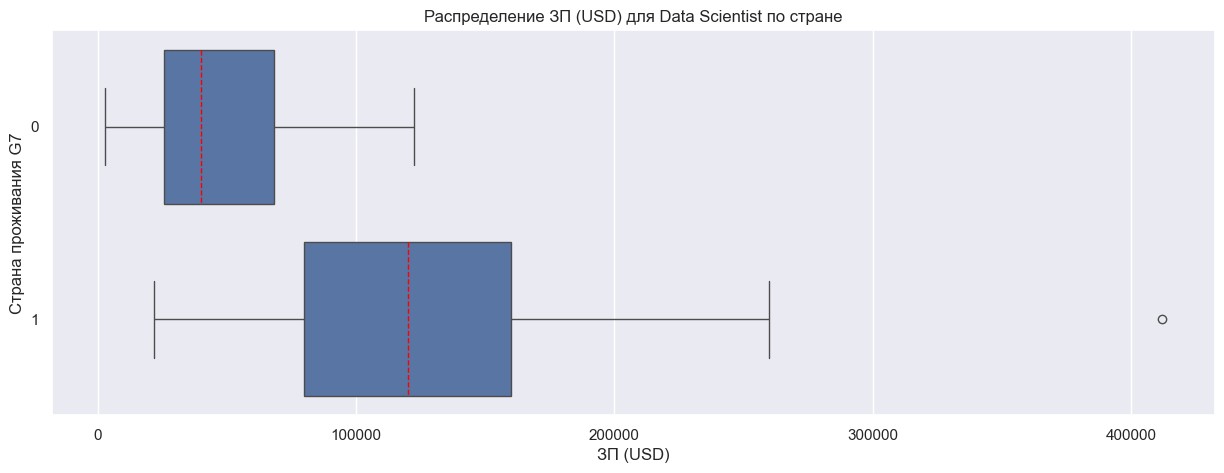

In [208]:
# вычислим признак
g7_country_codes = ['GB', 'GE', 'IT', 'CA', 'US', 'FR', 'JP']
data_ds['g7_country'] = data_ds['employee_residence'].apply(lambda x: 1 if x in g7_country_codes else 0)

# построим коробчатую диаграмму размера ЗП для каждого значения g7_country
ax = sns.boxplot(data_ds, x="salary_in_usd", y="g7_country", orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(ylabel='Страна проживания G7')
ax.set(xlabel='ЗП (USD)')
ax.set_title('Распределение ЗП (USD) для Data Scientist по стране')
plt.show();

## Вывод

Из диаграммы мы можем сказать, что доходы Data Scientist проживающих в странах G7 значительно выше, чем их коллег из других стран.

Проверим это утверждение с помощью статистических тестов

**Сформулируем нулевую и альтернативные гипотезы**

- *Нулевая гипотеза* ($H_0$): доход специалистов Data Scientist в странах G7 ($μ_0$) меньше либо равен доходу Data Scientist в других странах ($μ_1$).

$$ H_0 : μ_0 <= μ_1$$

- *Альтернативная гипотеза* ($H_1$): доход специалистов Data Scientist в странах G7 ($μ_0$) больше дохода Data Scientist в других странах ($μ_1$).

$$ H_1 : μ_0 > μ_2$$


**Проверим данные на нормальность**

In [209]:
g7_salaties_usd = data_ds[data_ds['g7_country']==1]['salary_in_usd']
other_salaties_usd = data_ds[data_ds['g7_country']==0]['salary_in_usd']

is_normal_distribution(g7_salaties_usd, 'Для специалистов из стран G7: ')
is_normal_distribution(other_salaties_usd, 'Для специалистов из других стран: ');

Для специалистов из стран G7:  p-значение 0.000 меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для специалистов из других стран:  p-значение 0.025 меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать *U-критерием Манна-Уитни*.

**Проведём тест**

In [213]:
_, p = stats.mannwhitneyu(g7_salaties_usd, other_salaties_usd, alternative='greater')
decline_zero_hypothesis(p);

p-значение 0.000 меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод

Доходы специалистов Data Scientist в странах G7 больше, чем доходы в других странах.

## Итоговые результаты исследования

- Доход специалистов Data Scientist меняется год к год
- Мы не можем утверждать что присутствует ежегодный рост ЗП для Data Scientist, но на отрезке 2021-2022 такой рост статистически значим
- Нет оснований утверждать, что доход Data Scientist больше, чем Data Engineer в 2022 году.
- Зарплаты специалистов Data Scientist в компаниях различных размеров отличаются
- Нет оснований говорить что существует связь между размером компании и наличии должностей Data Scientist и Data Engineer
- Доходы специалистов Data Scientist в странах G7 больше, чем доходы в других странах.